### Data loading and preprocessing

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [3]:
#Load data
df = pd.read_json(r'C:\Code\ML_Project\Data\preprocessed_movieDB.json')
df=df[df['revenue']<100*1e+6]

In [4]:
scaler = MinMaxScaler()
df['budget'] = scaler.fit_transform(df['budget'].values.reshape(-1, 1))

In [5]:
# Creating binning
bin_size =20
df['revenue_bin'] = np.floor(df['revenue'] / (bin_size*1e+6 )).astype(int)

In [6]:
#Create feature and class target
X = df.drop(['title', 'revenue', 'revenue_bin'], axis=1)
y = df['revenue_bin']

In [7]:
# Standard scale
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [8]:
#Train, validation, test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Finetune model

In [58]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7,9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 200],
}


In [59]:
grid_search = GridSearchCV(XGBClassifier(), 
                           param_grid=param_grid, verbose= 6) 
grid_search.fit(X_train, y_train) 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6;, score=0.687 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6;, score=0.696 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6;, score=0.676 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6;, score=0.670 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.6;, score=0.683 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.687 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.690 total time=   0.0s
[CV 3/5] END learning_rate

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=6)

In [63]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 200,
 'subsample': 0.6}

In [81]:
model_random = grid_search.best_estimator_
y_pred_rand = model_random.predict(X_test) 
print(confusion_matrix(y_test, y_pred_rand))

[[307  22   4   2   1]
 [ 35  40   5   5   0]
 [ 13  11   5   8   3]
 [  8   3   4   6   7]
 [  3   8   4   5   4]]


In [82]:
f1 = f1_score(y_test, y_pred_rand, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.6856022228448332


### Using with hyperparameter

In [9]:
model = XGBClassifier(learning_rate = 0.1, max_depth = 3, min_child_weight =3, n_estimators = 200, subsample = 0.6)
model.fit(X_train,y_train)
y_pred = model.predict(X_test) 

In [10]:
cx= confusion_matrix(y_test, y_pred)

In [11]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.6981245644243557


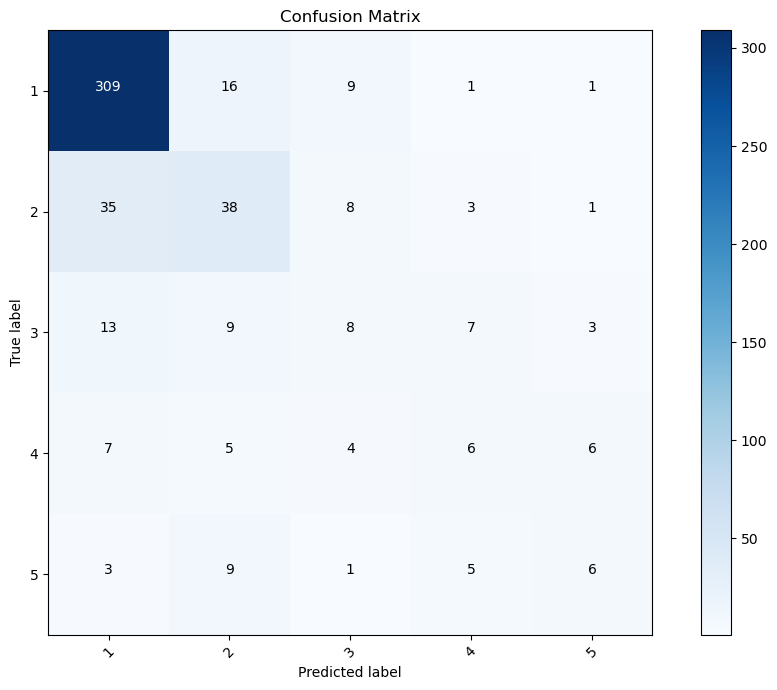

In [12]:
plt.figure(figsize=(10, 7))
plt.imshow(cx, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['1', '2', '3', '4', '5']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cx.max() / 2.
for i in range(cx.shape[0]):
    for j in range(cx.shape[1]):
        plt.text(j, i, format(cx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cx[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [14]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       336
           1       0.49      0.45      0.47        85
           2       0.27      0.20      0.23        40
           3       0.27      0.21      0.24        28
           4       0.35      0.25      0.29        24

    accuracy                           0.72       513
   macro avg       0.45      0.41      0.42       513
weighted avg       0.69      0.72      0.70       513

